Install your libraries

In [ ]:
!pip install pandas matplotlib numpy cython
!pip install pystan
!pip install fbprophet



# PART 1. Data Pre-processing

<h3>Step #0. Fire the system</h3>

In [1]:
%matplotlib inline
import pandas as pd
from fbprophet import Prophet

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

<h3>Step #1. Read data</h3>

In [2]:
df = pd.read_csv('stock_prices.csv')
df['Date'] = pd.DatetimeIndex(df['Date'])
df.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object

<h3>Step #2. Data pre-processing</h3>
<p>
Removing all commas and convert data to matrix shape format.
</p>

In [3]:
# don't rename Month --use for index, can't index ds, Prophet will complain
#df = df.rename(columns={'Month': 'ds','AirPassengers': 'y'})
df['ds']=df["Date"]  
df = df.rename(columns={'Close': 'y'})  
df.head(5) #1949-01 -> 1960-12

,Date,Open,High,Low,y,Volume,ds
0,2013-01-02,7.000,7.09,6.942,7.072,5974000,2013-01-02
1,2013-01-03,7.036,7.09,6.950,6.954,3710000,2013-01-03
2,2013-01-04,6.960,6.96,6.784,6.880,3370000,2013-01-04
3,2013-01-07,6.960,6.96,6.780,6.868,2210000,2013-01-07
4,2013-01-08,6.900,6.90,6.622,6.736,6420000,2013-01-08


In [4]:
#df['ds'] = pd.DatetimeIndex(df['ds'])
#df.index #RangeIndex
df = df.set_index('Date') # don't set index on 'ds'
df.index #DateteimIndex
#df['1959':]

DatetimeIndex(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-07',
               '2013-01-08', '2013-01-09', '2013-01-10', '2013-01-11',
               '2013-01-14', '2013-01-15',
               ...
               '2021-06-16', '2021-06-17', '2021-06-18', '2021-06-21',
               '2021-06-22', '2021-06-23', '2021-06-24', '2021-06-25',
               '2021-06-28', '2021-06-29'],
              dtype='datetime64[ns]', name='Date', length=2138, freq=None)

In [5]:
df = df[['y','ds']]

In [ ]:
train_data = df[:"2021-06-15"] #1949-01 -> 1959-12
print(train_data.index)
test_data = df["2021-06-15":] #1960-01 => 1960-12
print(test_data.index)


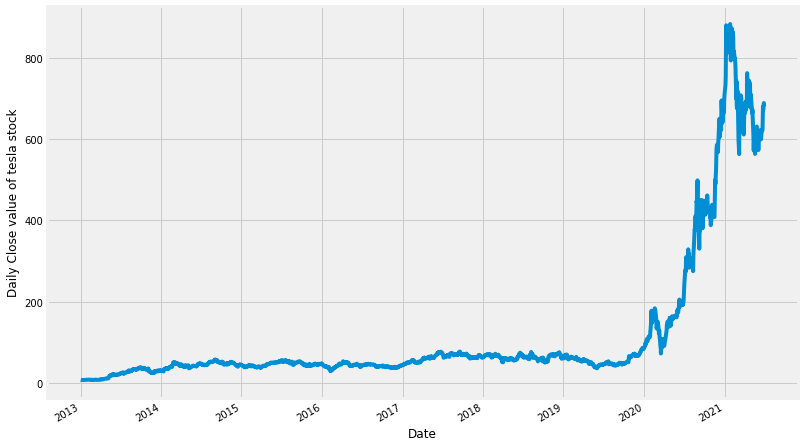

In [7]:
#df = df.set_index('ds') # done on top
ax = df['y'].plot(figsize=(12, 8))
ax.set_ylabel('Daily Close value of tesla stock')
ax.set_xlabel('Date')

plt.show()

In [8]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95,  daily_seasonality= True)
                 
my_model.fit(train_data)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [9]:
future_dates = my_model.make_future_dataframe(periods=14, freq='D')
future_dates.drop(future_dates.index[[2131,2132]], inplace=True)

<h2>PART 2. Create a model. Training</h2>

In [10]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2135,2021-06-25,765.623189,678.991313,849.534178
2136,2021-06-26,768.289783,684.638178,852.338601
2137,2021-06-27,770.390783,683.480626,857.614554
2138,2021-06-28,772.616113,687.106658,851.997656
2139,2021-06-29,774.747493,694.013439,865.287698


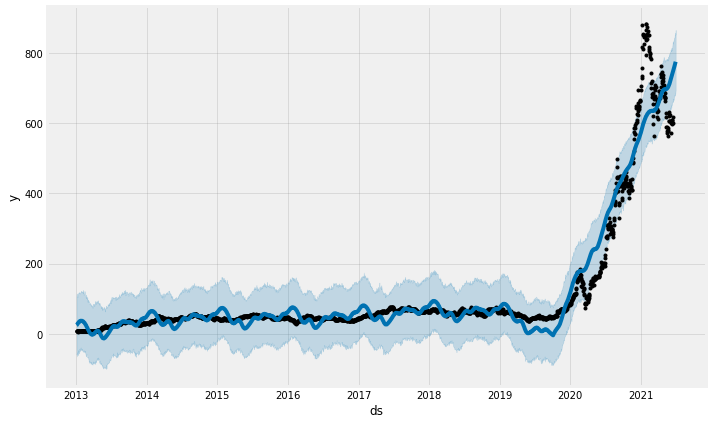

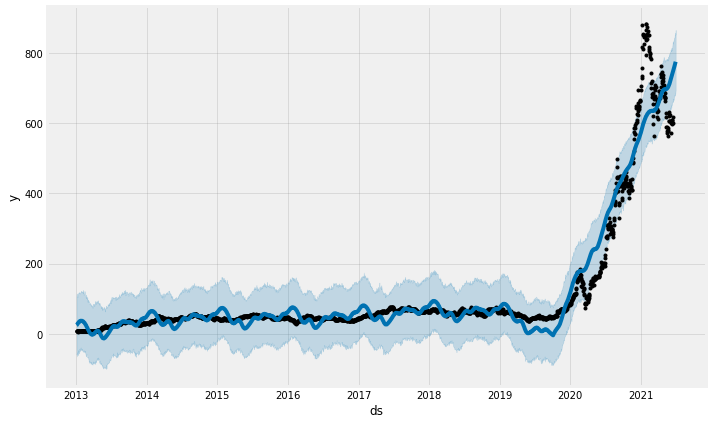

In [11]:
my_model.plot(forecast, uncertainty=True)

**The model used all the data for the training (black dots) and predicted the future stock price from June 2013 till June 2021 ! Blue shadow is the confidence interval.**

Conclusion: It seems that the Google Stock price will be around 751 in 2021-06-15 based on the model’s prediction.

<h3>Step #3. Metrics</h3>

In [12]:
pd.options.mode.chained_assignment = None  # default='warn' supress warning

yhat = forecast[-11:]["yhat"]
test_data["yhat"] = yhat[0:12].to_numpy()
test_data['yhat_lower'] = forecast[-11:][['yhat_lower']].to_numpy()
test_data['yhat_upper'] = forecast[-11:][['yhat_upper']].to_numpy()

mae = abs(test_data["y"] - test_data["yhat"]).mean()
print("MAE:", mae) #33.91 vs 19.5 (ARIMA)

import numpy as np
MSE = ((test_data["y"] - test_data["yhat"])**2).mean()
RMSE = np.sqrt(MSE)
print("RMSE:", RMSE)

MAE: 120.95776545894574
RMSE: 123.47568498992443


<h3><h2>PART 3. Make future predictions</h2></h3>

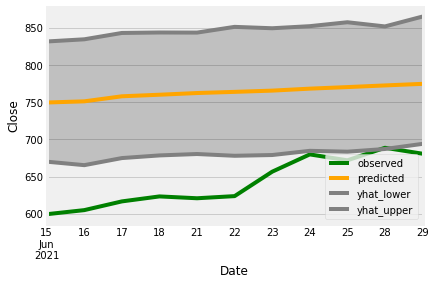

In [13]:
ax = test_data['y'].plot(label='observed', color='green')
ax = test_data['yhat'].plot(label='predicted', color='orange')
ax = test_data['yhat_lower'].plot(label='yhat_lower', color="gray")
ax = test_data['yhat_upper'].plot(label='yhat_upper', color="gray")
ax.fill_between(test_data.index,
                test_data['yhat_lower'],
                test_data['yhat_upper'], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Close')
plt.legend()

plt.show()

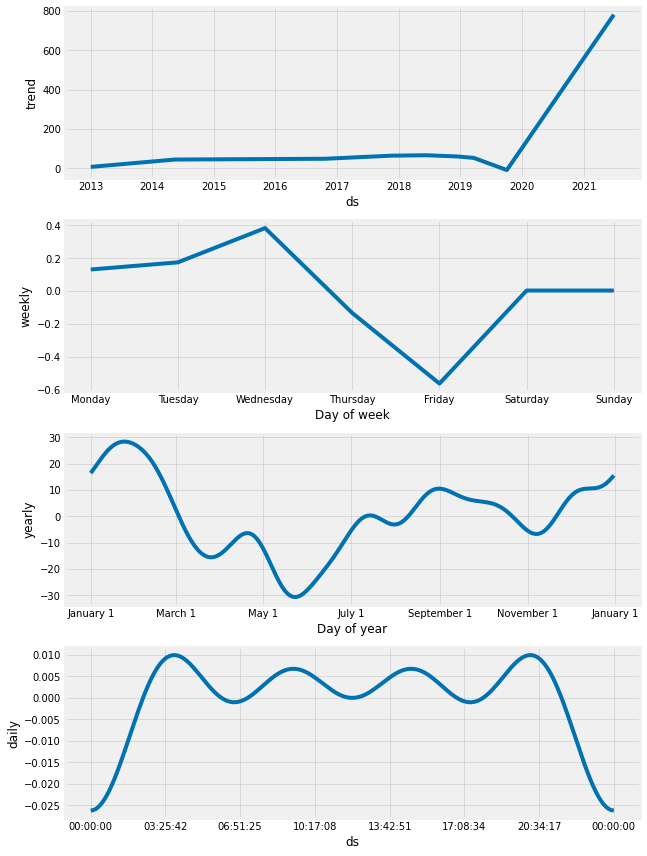

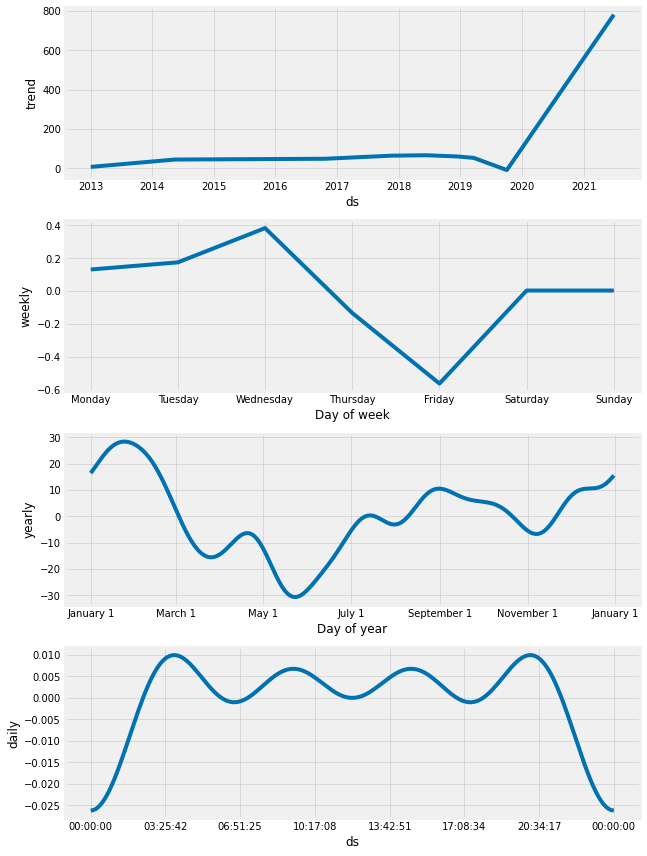

In [16]:
my_model.plot_components(forecast, weekly_start=1)

In [ ]:
pip install pmdarima

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

In [19]:
df = pd.read_csv('stock_prices.csv')
df = df[['Close', 'Date']]

In [20]:
df['Date'] = pd.DatetimeIndex(df['Date'])

In [21]:
full_dates = pd.DataFrame(pd.date_range(start = '2014-12-17', end = '2021-06-29', freq = 'D'), columns=['Date'])
df = pd.merge(full_dates, df, how='left', on='Date').fillna(method='bfill')


In [ ]:
df = df.set_index("Date")

[Text(0, 0.5, 'Total Production'), Text(0.5, 0, 'Dates')]

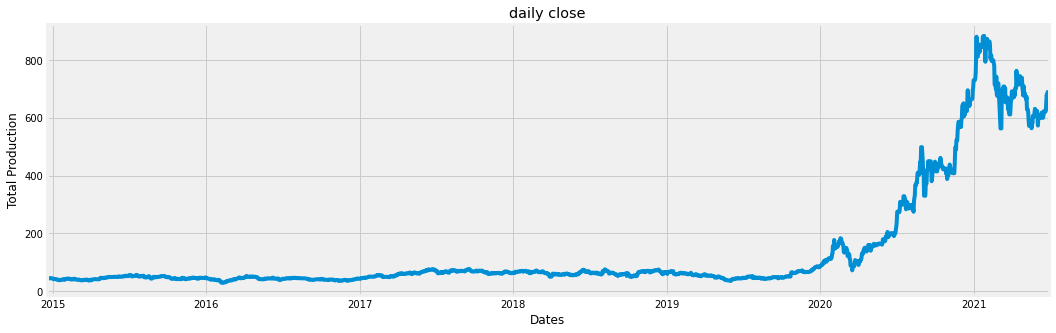

In [23]:
df.index.freq = 'd'
ax = df['Close'].plot(figsize = (16,5), title = "daily close")
ax.set(xlabel='Dates', ylabel='Total Production')

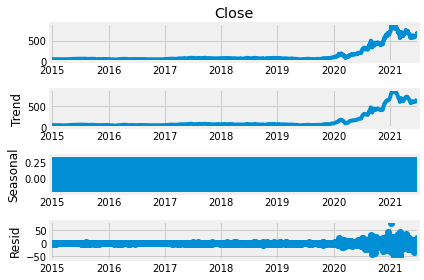

In [24]:
a = seasonal_decompose(df["Close"], model = "add")
a.plot();

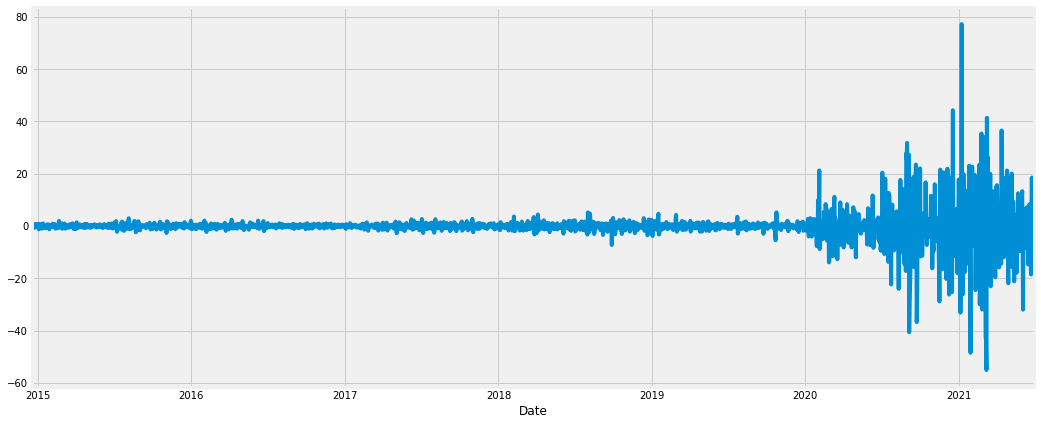

In [25]:
plt.figure(figsize = (16,7))
a.resid.plot();

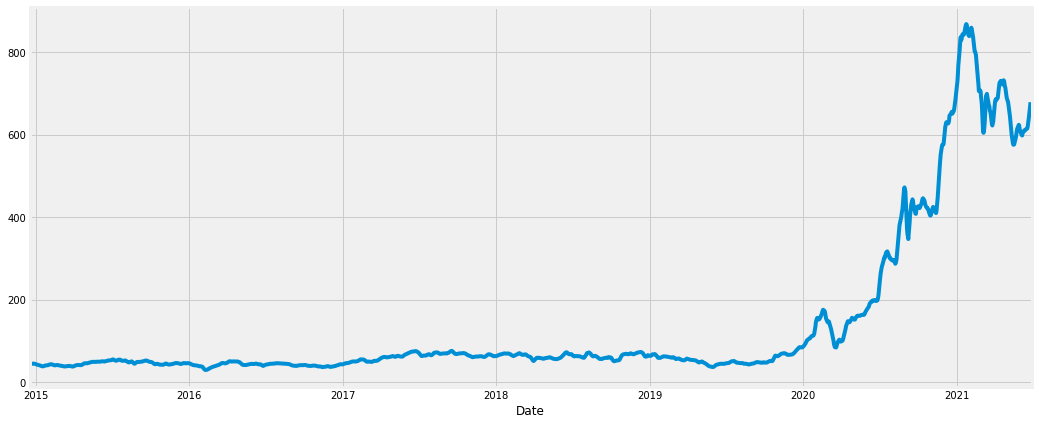

In [26]:
plt.figure(figsize = (16,7))
a.trend.plot();

In [27]:
#ARIMA Forecast
#Finding the best values for p,q,d,P,Q,D

auto_arima(df['Close'], seasonal=True, m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2387
Model:             SARIMAX(7, 2, 0)x(1, 0, 0, 12)   Log Likelihood               -8500.690
Date:                            Thu, 06 Jan 2022   AIC                          17019.381
Time:                                    14:07:27   BIC                          17071.373
Sample:                                         0   HQIC                         17038.302
                                           - 2387                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8932      0.008   -108.833      0.000      -0.909      -0.877
ar.L2         -0.6746      0.009    -77.138      0.000      -0.692      -0.657
ar.L3         -0.5150      0.010    -50.251      0.000      -0.535      -0.495
ar.L4         -0.4612      0.013    -35.812      0.000      -0.486      -0.436
ar.L5         -0.3123      0.014    -22.479      0.000      -0.340      -0.285
ar.L6         -0.1614      0.012    -13.000      0.000      -0.186      -0.137
ar.L7         -0.1311      0.011    -12.394      0.000      -0.152      -0.110
ar.S.L12       0.0429      0.010      4.449      0.000       0.024       0.062
sigma2        72.9718      0.494    147.604      0.000      72.003      73.941
===================================================================================
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):            193755.89
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):             239.09   Skew:                             0.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        47.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
train_data = df[:len(df)-15]
test_data = df[len(df)-15:]
arima_model = SARIMAX(train_data['Close'], order = (2,1,1), seasonal_order = (4,0,3,12))
arima_result = arima_model.fit()
arima_result.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                      Close   No. Observations:                 2372
Model:             SARIMAX(2, 1, 1)x(4, 0, [1, 2, 3], 12)   Log Likelihood               -8292.140
Date:                                    Thu, 06 Jan 2022   AIC                          16606.279
Time:                                            14:08:28   BIC                          16669.761
Sample:                                        12-17-2014   HQIC                         16629.388
                                             - 06-14-2021                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1516      0.113      1.347      0.178      -0.069       0.372
ar.L2          0.0825      0.009      9.302      0.000       0.065       0.100
ma.L1         -0.1930      0.112     -1.730      0.084      -0.412       0.026
ar.S.L12       0.1801      0.430      0.418      0.676      -0.663       1.024
ar.S.L24       0.4521      0.235      1.921      0.055      -0.009       0.913
ar.S.L36       0.1649      0.411      0.401      0.689      -0.641       0.971
ar.S.L48       0.0238      0.014      1.674      0.094      -0.004       0.052
ma.S.L12      -0.1581      0.426     -0.371      0.711      -0.994       0.678
ma.S.L24      -0.4396      0.232     -1.897      0.058      -0.894       0.015
ma.S.L36      -0.1818      0.400     -0.454      0.650      -0.966       0.603
sigma2        63.8181      0.479    133.114      0.000      62.878      64.758
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            161423.74
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):             244.10   Skew:                             0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        43.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
#Prediction
arima_pred = arima_result.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

2021-06-15    617.771436
2021-06-16    618.085558
2021-06-17    619.849097
2021-06-18    618.446755
2021-06-19    618.268457
2021-06-20    617.058106
2021-06-21    616.723678
2021-06-22    616.254642
2021-06-23    616.887264
2021-06-24    619.024759
2021-06-25    618.199161
2021-06-26    617.471682
2021-06-27    617.540369
2021-06-28    617.334317
2021-06-29    617.083318
Freq: D, Name: ARIMA Predictions, dtype: float64

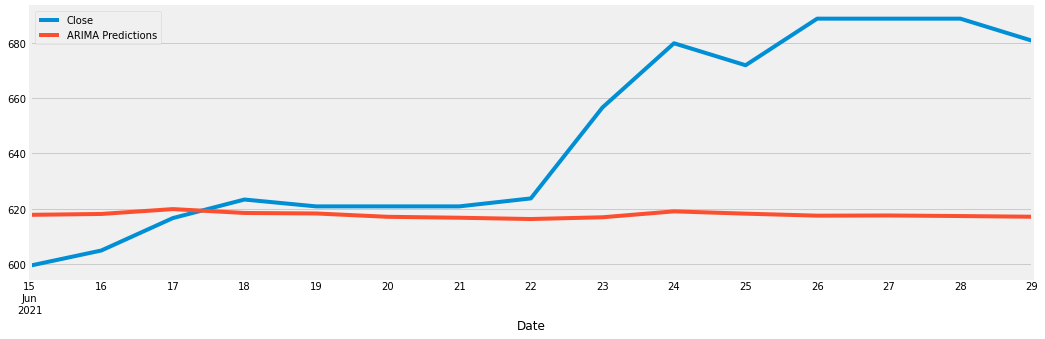

In [30]:
test_data['Close'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [31]:
#Model Evaluation
arima_rmse_error = rmse(test_data['Close'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['Close'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 1872.393462114793
RMSE Error: 43.271162014843014
Mean: 138.8307245643065


In [32]:
test_data['Arima_pred'] = arima_pred

In [33]:
df_pr = df.copy()
df_pr = df.reset_index()
df_pr.columns = ['ds','y'] # To use prophet column names should be like that
train_data_pr = df_pr.iloc[:len(df)-14]
test_data_pr = df_pr.iloc[len(df)-14:]

In [ ]:
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-15:]['ds'], "Pred" : prophet_pred[-15:]["yhat"]})
prophet_pred = prophet_pred.set_index("Date")
prophet_pred.index.freq = "d"


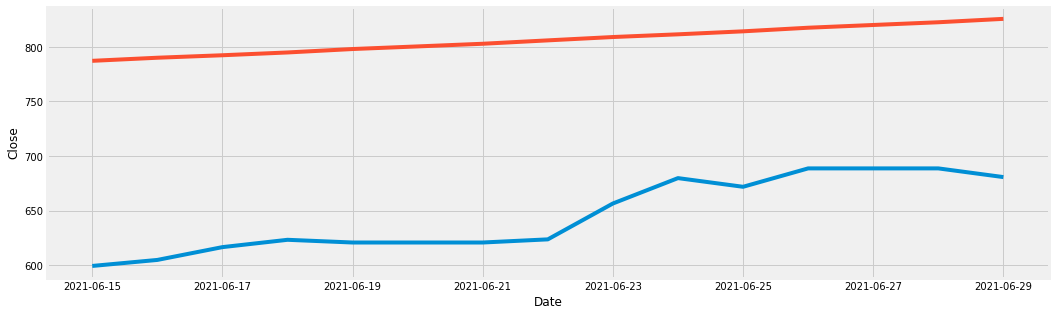

In [37]:
test_data["Prophet_Predictions"] = prophet_pred['Pred'].values
import seaborn as sns
plt.figure(figsize=(16,5))
ax = sns.lineplot(x= test_data.index, y=test_data["Close"])
sns.lineplot(x=test_data.index, y = test_data["Prophet_Predictions"], legend=['Original', 'Prophet']);

In [39]:
prophet_rmse_error = rmse(test_data['Close'], test_data["Prophet_Predictions"])
prophet_mse_error = prophet_rmse_error**2
mean_value = df['Close'].mean()

print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}')

MSE Error: 26244.229737904792
RMSE Error: 162.0007090660556
Mean: 138.8307245643065


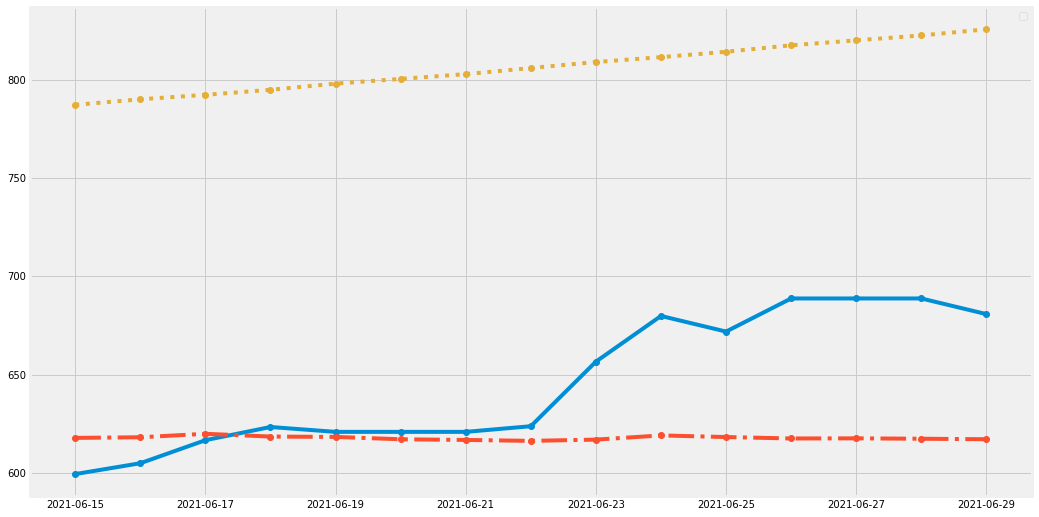

In [40]:
#Comparison

rmse_errors = [arima_rmse_error, prophet_rmse_error]
mse_errors = [arima_mse_error, prophet_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})
plt.figure(figsize=(16,9))
plt.plot_date(test_data.index, test_data["Close"], linestyle="-")
plt.plot_date(test_data.index, test_data["Arima_pred"], linestyle="-.")
plt.plot_date(test_data.index, test_data["Prophet_Predictions"], linestyle=":")
plt.legend()
plt.show()


In [41]:
print(f"Mean: {test_data['Close'].mean()}")
errors

Mean: 645.7013306000002


,Models,RMSE Errors,MSE Errors
0,ARIMA,43.271162,1872.393462
1,Prophet,162.000709,26244.229738


In [42]:
#Final Prediction data
test_data

,Close,Arima_pred,Prophet_Predictions
Date,,,
2021-06-15,599.359985,617.771436,787.251045
2021-06-16,604.869995,618.085558,790.086938
2021-06-17,616.599976,619.849097,792.359570
2021-06-18,623.309998,618.446755,794.914609
2021-06-19,620.830017,618.268457,798.062236
2021-06-20,620.830017,617.058106,800.459297
2021-06-21,620.830017,616.723678,802.887908
2021-06-22,623.710022,616.254642,805.992344
2021-06-23,656.570007,616.887264,809.051655


In [43]:
test_data.to_csv('Arima+Prophet')